# Risk-Averse RL in a Driving Game

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import gym
import time
import DrivingSim, DrivingLab
import Agents
import utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

### The Driving benchmark

A sample episode of a random agent:

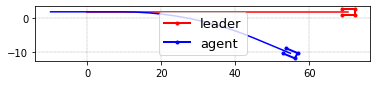

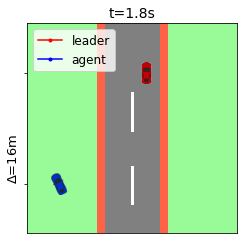

In [2]:
# Make sure the environment is registered
if 'DrivingSim-v0' in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs['DrivingSim-v0']
gym.envs.registration.register(id='DrivingSim-v0', entry_point='DrivingSim:DrivingSim')

# Run a sample episode with random actions
env = gym.make('DrivingSim-v0')
env.reset()
done = False
while not done:
    obs, r, done, info = env.step(env.action_space.sample())
env.show_trajectory()
env.show_frame()
plt.tight_layout()

env.close()

### CE for risk-averse RL-based driver

Training 3/3 remaining agents...
Training 3 agents...
Waiting for trainings...
Waiting for processes...
Done.	(26485s)
Waiting for tests...
Waiting for processes...
Done.	(146s)
PG (420/500):	mean=-260.2	CVaR05=-488.9	CVaR01=-753.9
GCVaR1 (490/500):	mean=-563.9	CVaR05=-713.9	CVaR01=-774.4
CE_SGCVaR1 (370/500):	mean=-311.9	CVaR05=-478.9	CVaR01=-540.6
CPU times: user 1min 19s, sys: 3.33 s, total: 1min 22s
Wall time: 7h 24min 46s


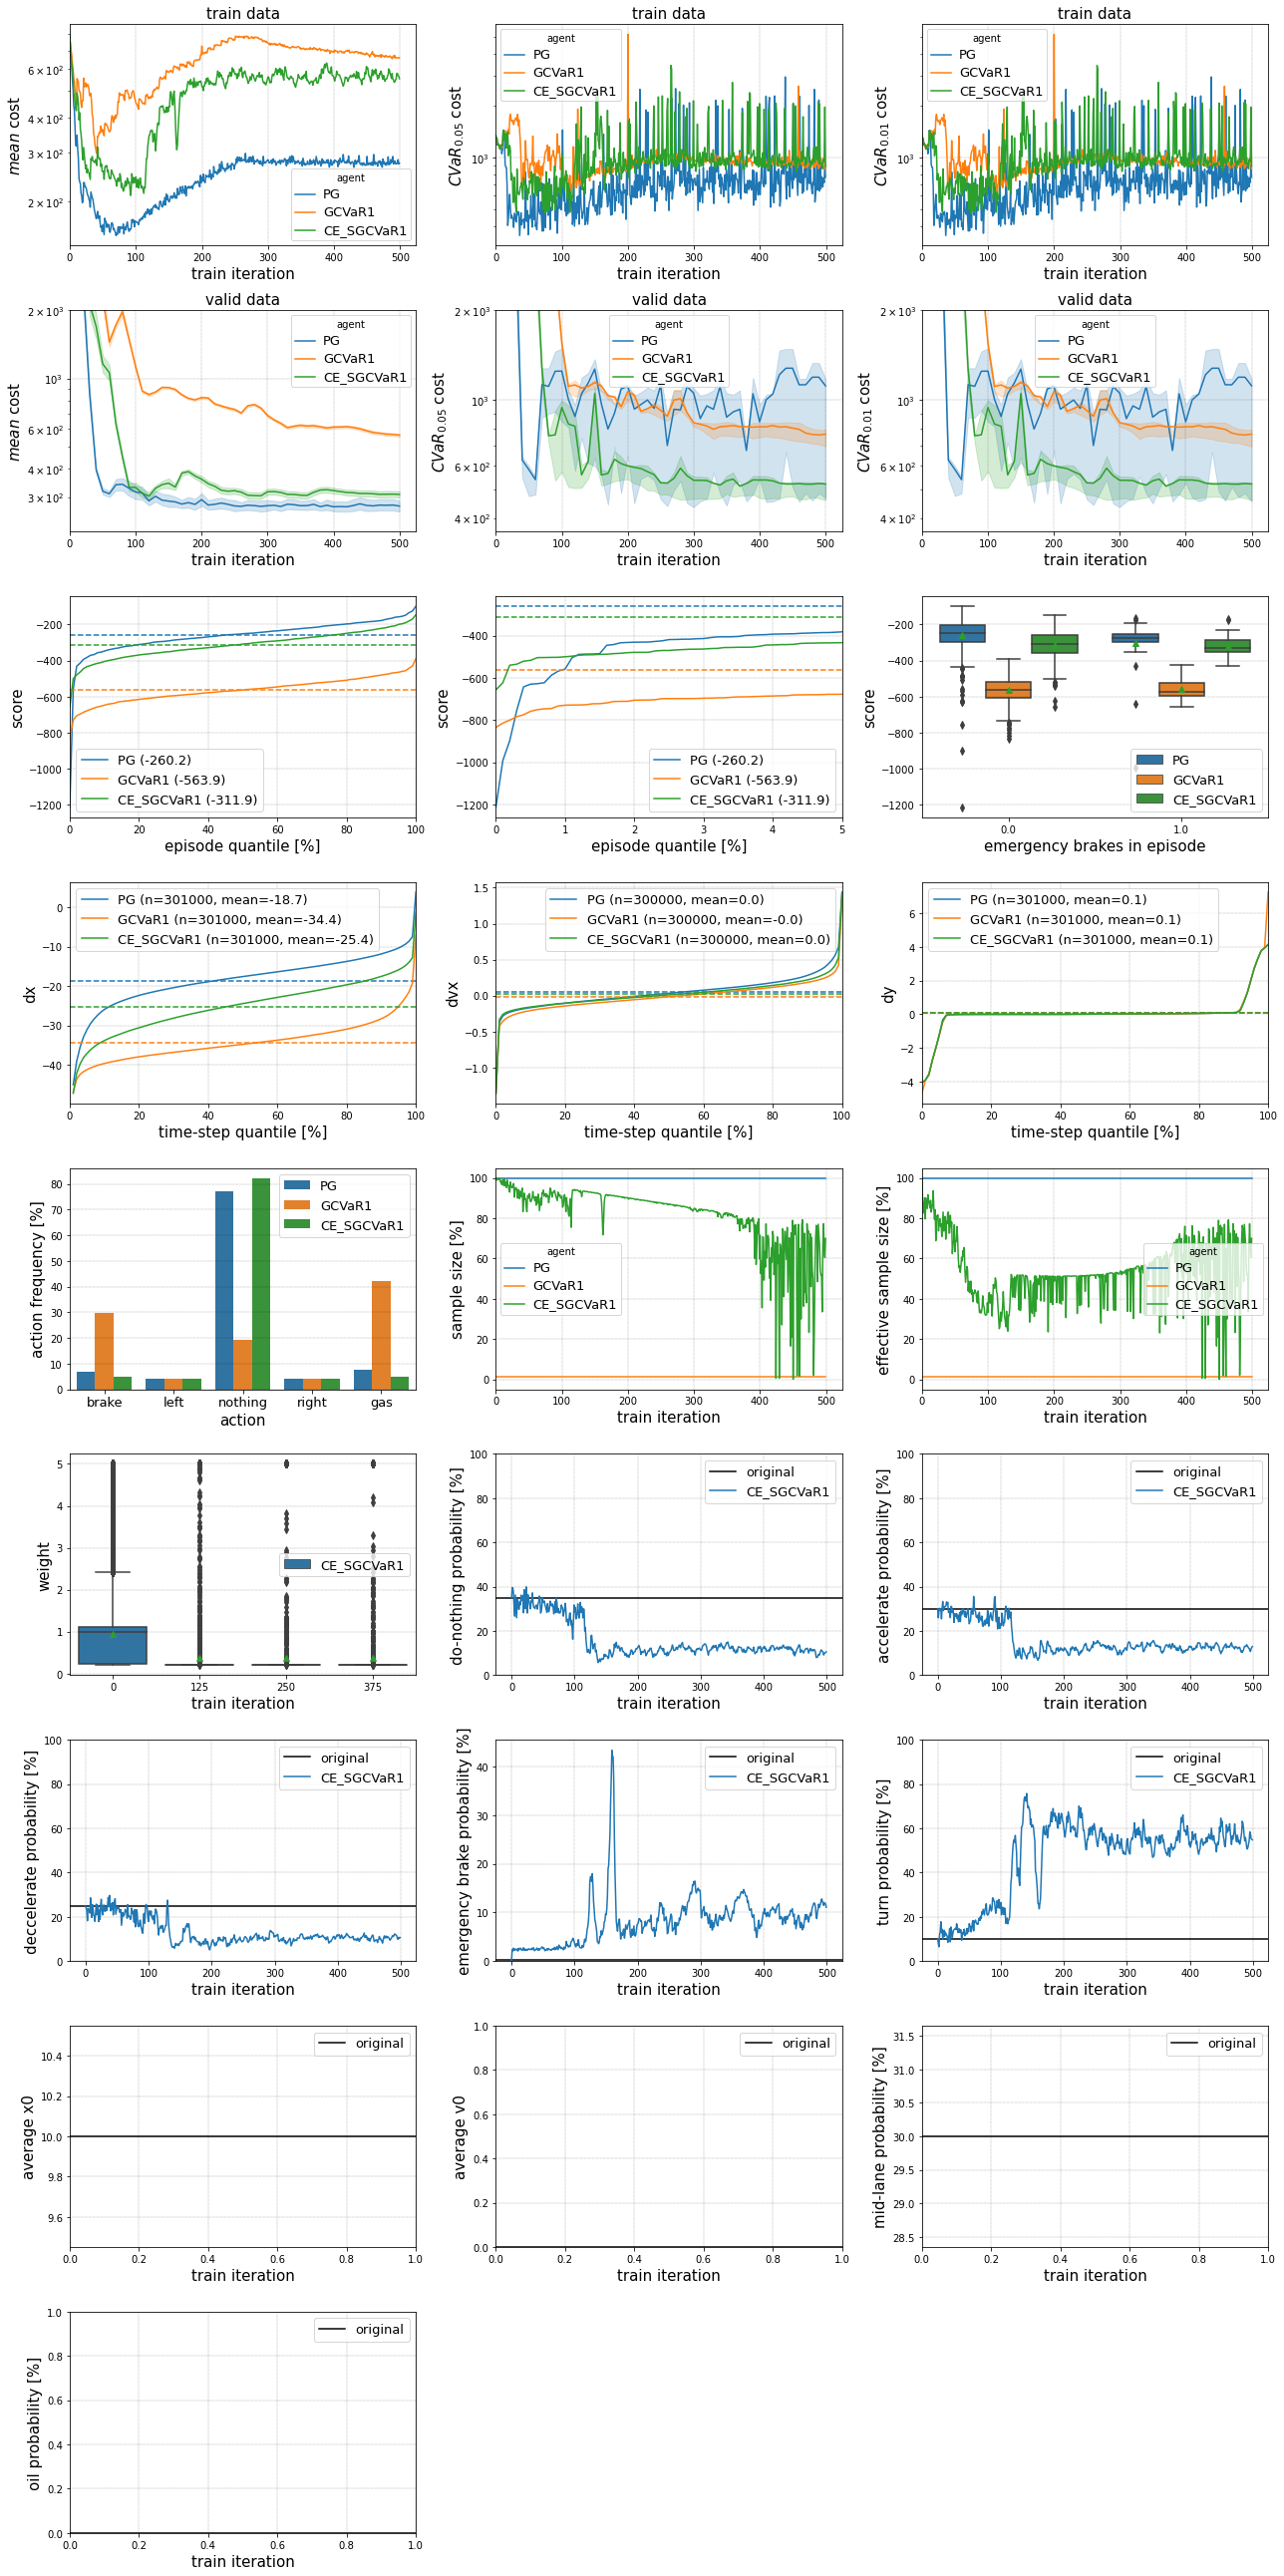

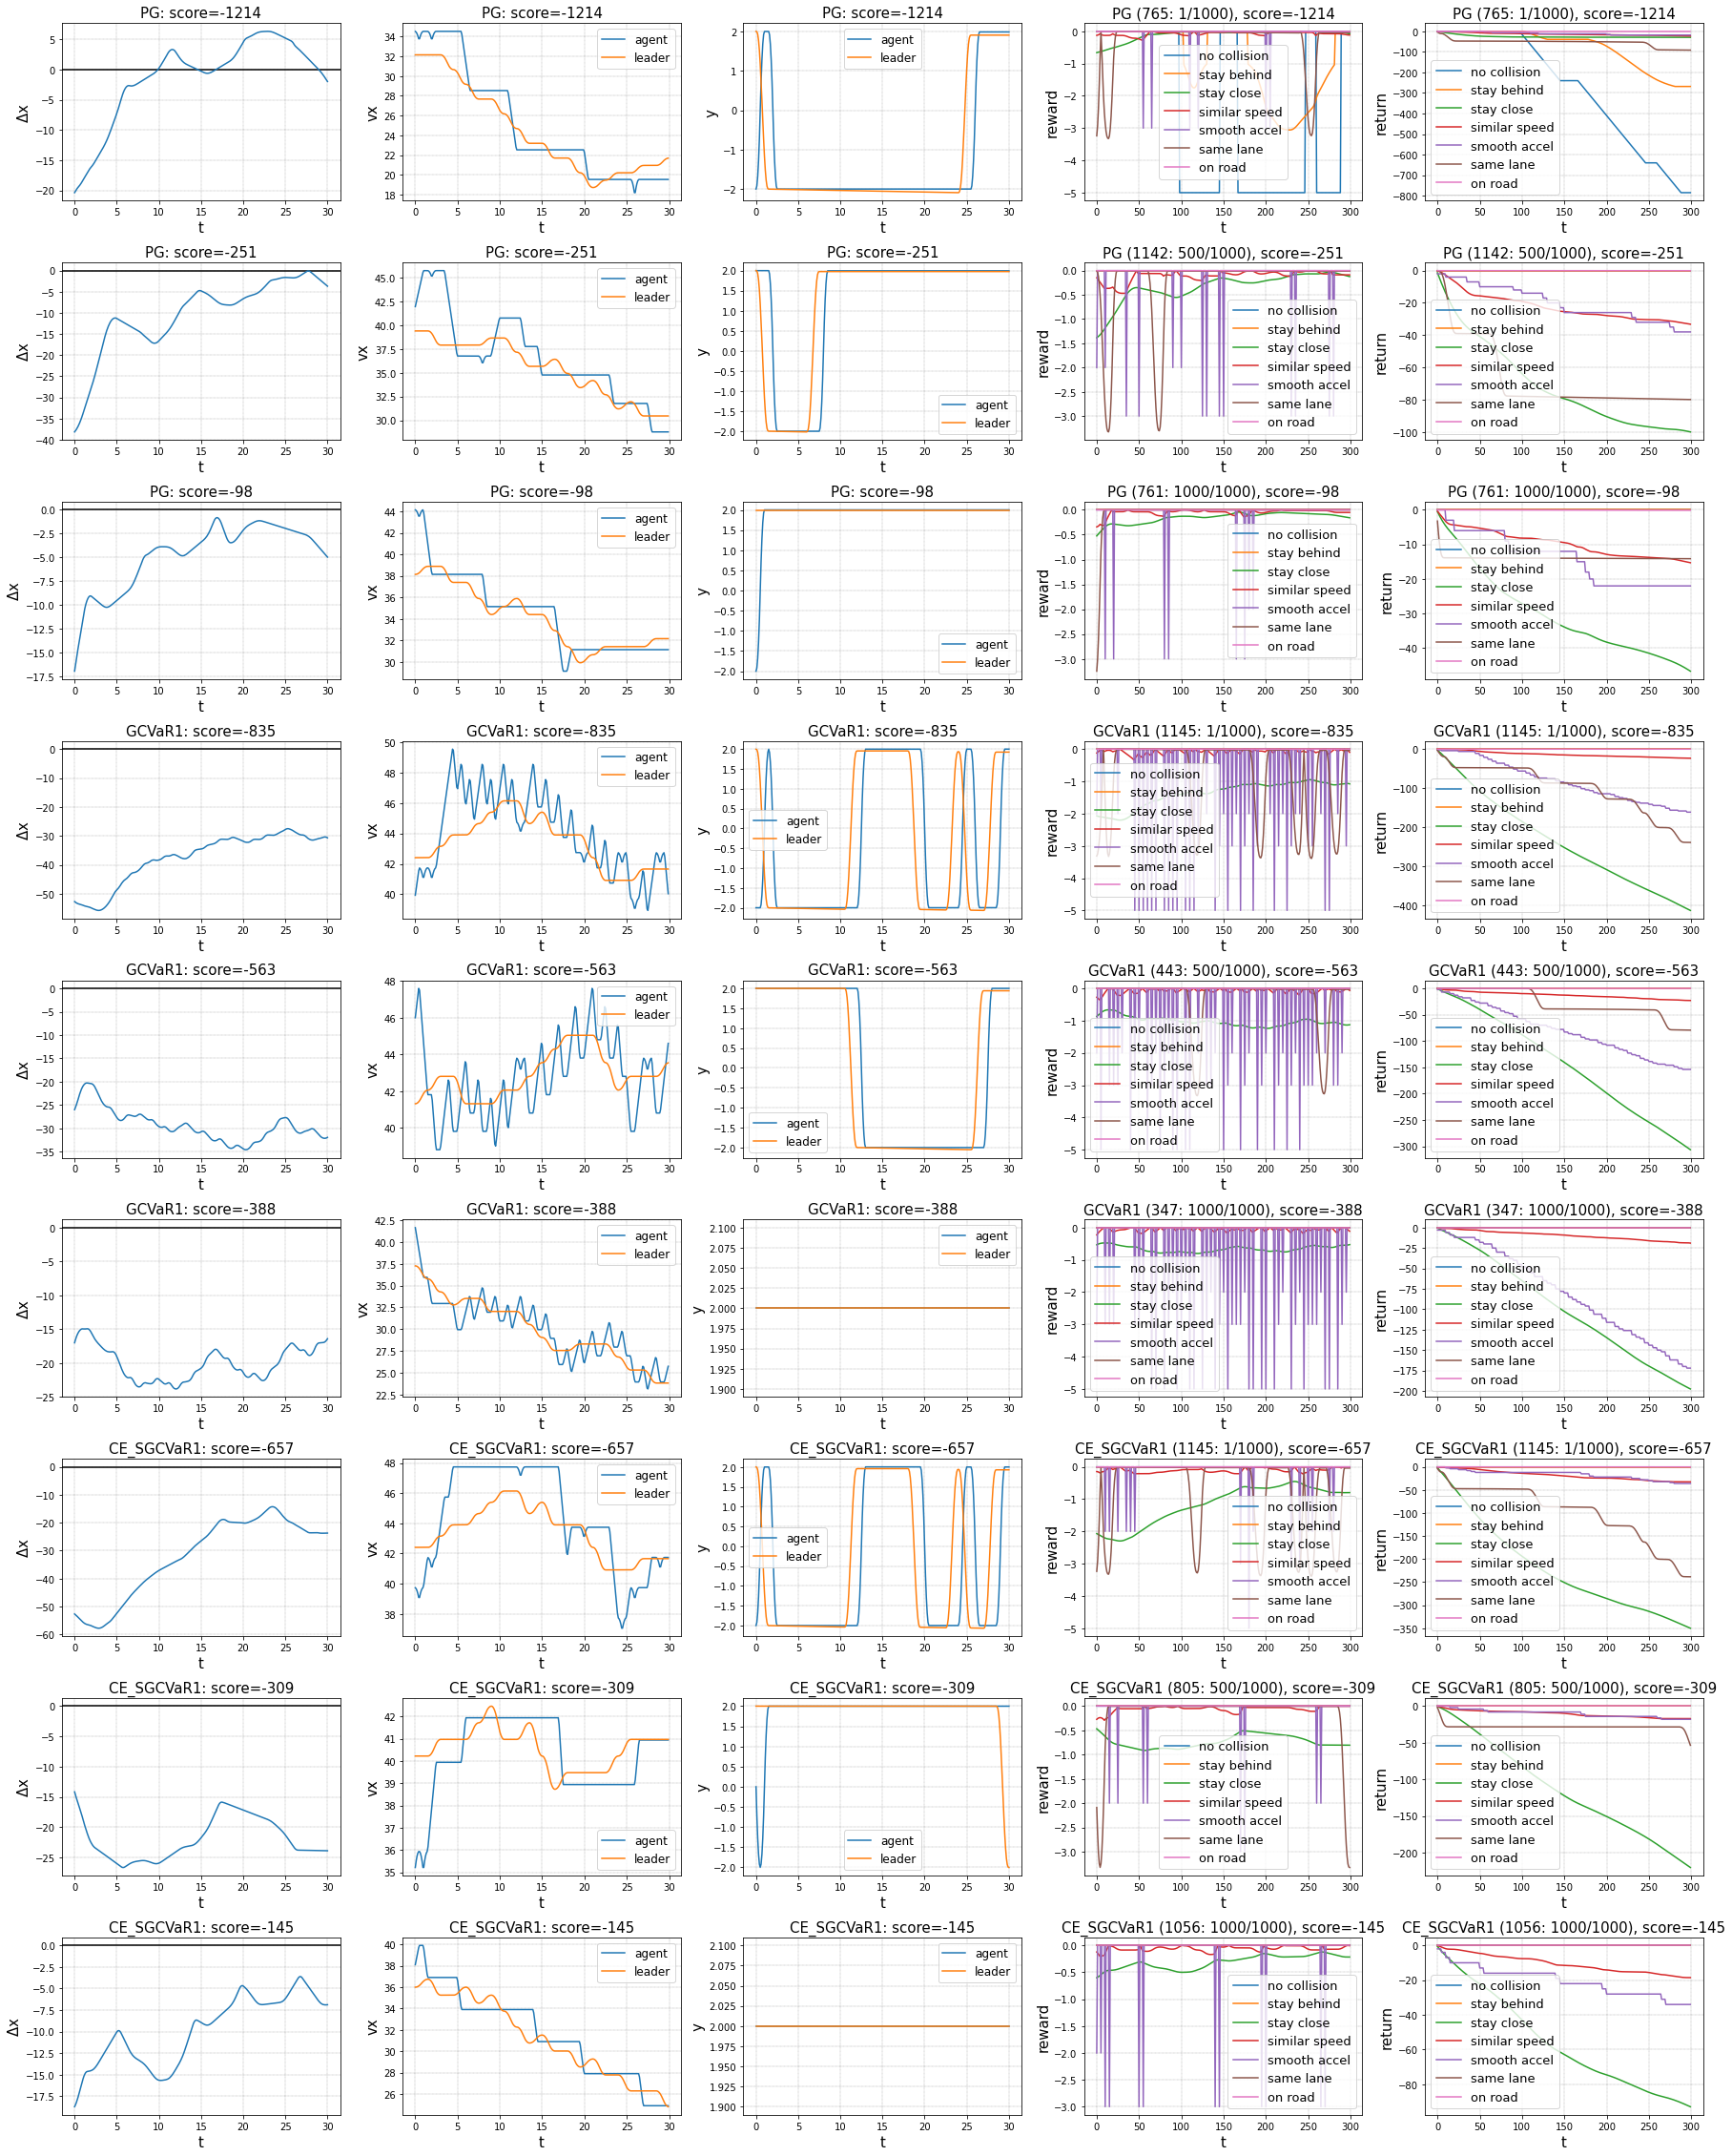

In [3]:
%%time

title = 'DrivingGameFinal'

# Define agents (note that the training hyperparams are also defined here through the dict train_hparams).
agents = dict(
    PG = (Agents.FC, dict(train_hparams=dict())),
    GCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.01))),
    CE_SGCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.01, ce_update_freq=1, soft_cvar=0.8))),
);

# Run experiment: setup, training, testing and analysis.
E = DrivingLab.Experiment(agents, train_episodes=200000, title=title)
axs = E.main()

# Save results and show a sample of episodes.
E.save_results()
plt.savefig(f'outputs/{title}_summary.png', bbox_inches='tight')
E.show_tests()
plt.savefig(f'outputs/{title}_examples.png', bbox_inches='tight');

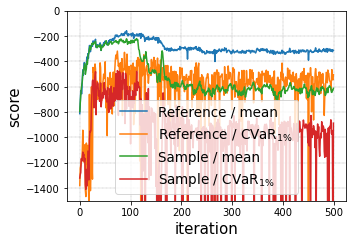

In [29]:
ax = E.CEs['CE_SGCVaR'].show_sampled_scores()
ax.set_ylim((-1500,0))
ax.legend(loc='lower center', fontsize=13.5)
plt.savefig(f'outputs/{title}_CE.png', bbox_inches='tight');

Bad test episodes:

In [10]:
d = E.dd
d[(d.group=='test')&(d.score<-700)]

,agent,group,episode,ag_updates,ag_hash,ag_temperature,p_0,p_acc,p_dec,p_hard,...,th0,brakes,oil,L,log_prob,ret_loss,score,opt_selected,ce_selected,weight
600347,PG,test,347,500,-0x316e790edaf3e293,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-8.778033,-146.321136,-898.133071,NaN,NaN,NaN
600765,PG,test,765,500,-0x316e790edaf3e293,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-5.191854,-125.653481,-1214.473103,NaN,NaN,NaN
600801,PG,test,801,500,-0x316e790edaf3e293,0,0.35,0.3,0.248,0.002,...,0.195738,1.0,NaN,30,-7.645064,-131.145630,-992.290154,NaN,NaN,NaN
600821,PG,test,821,500,-0x316e790edaf3e293,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-7.974699,-95.708107,-755.780086,NaN,NaN,NaN
601435,GCVaR1,test,235,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-19.266087,-204.450623,-705.498844,NaN,NaN,NaN
601519,GCVaR1,test,319,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-20.069786,-232.533966,-800.414115,NaN,NaN,NaN
601689,GCVaR1,test,489,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-17.743486,-200.724838,-722.441794,NaN,NaN,NaN
601720,GCVaR1,test,520,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-12.228050,-135.786041,-729.714635,NaN,NaN,NaN
601727,GCVaR1,test,527,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-21.451048,-238.230362,-703.488696,NaN,NaN,NaN
601743,GCVaR1,test,543,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,-0.209604,0.0,NaN,30,-19.530138,-231.516739,-774.982221,NaN,NaN,NaN


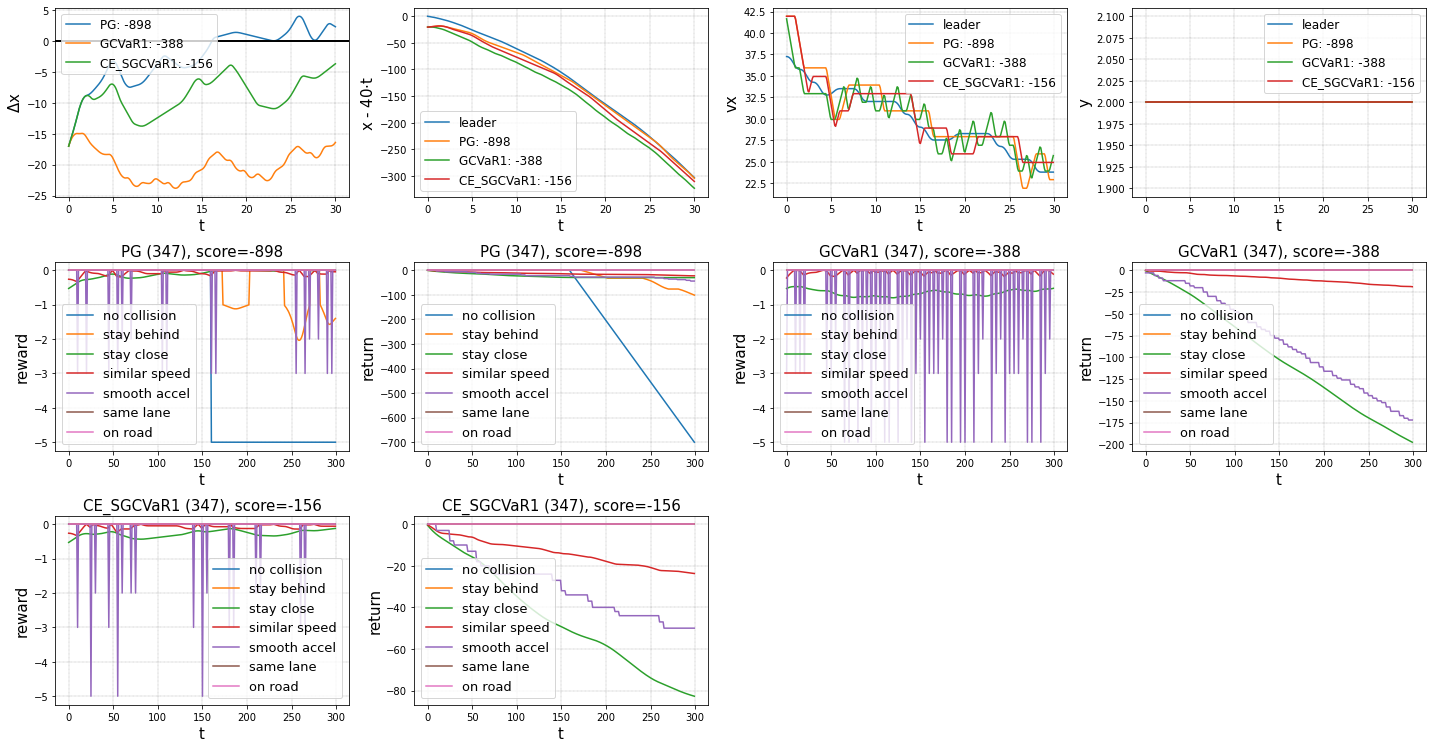

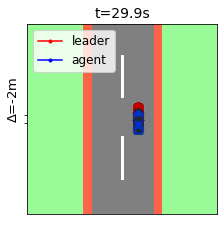

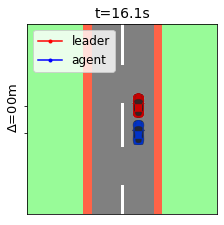

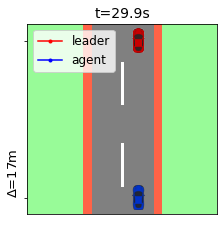

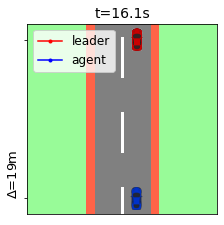

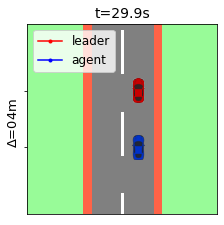

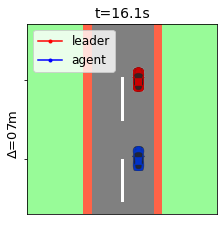

In [17]:
episode = 347
E.analyze_episode(episode)
for agent in E.agents_names:
    E.run_episode((agent, 'test', episode), agent, gif=True)
    E.env.show_frame(161)
    plt.savefig(f'outputs/{title}_{agent}_ep347_frm161.png', bbox_inches='tight')